# Guassian mixture intra-song clustering for identification of "main" beats

Code for doing tests

In [4]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import math

from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA

from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks, get_beat_data, get_audio_data
from groove.embedding import bar_embedding, load_bar_embedding, load_bar_embedding_total, bar_embedding_total
from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks, get_beat_data, get_audio_data
from groove.intraclustering import get_ellipse_patch, get_patches, winnow_gm_components, ellipse_contains_points, find_closest_indices


def simulate_num_components(data, num_trials, confidence_limit=0.9, cluster_threshold=0.2, overlap_allowance=0.1, use_weights=False):
    counts = {}
    for _ in range(num_trials):
        n_components = winnow_gm_components(data, confidence_limit=confidence_limit, cluster_threshold=cluster_threshold, overlap_allowance=overlap_allowance, use_weights=use_weights).means_.shape[0]
        if n_components in counts:
            counts[n_components] += 1
        else:
            counts[n_components] = 1
    return counts




def do_clustering(data, confidence_limit=0.9, cluster_threshold=0.2, overlap_allowance=0.1, use_weights=False, verbose=False):
    gm = winnow_gm_components(data, confidence_limit=confidence_limit, cluster_threshold=cluster_threshold, overlap_allowance=overlap_allowance, use_weights=use_weights, verbose=verbose)
    print(f"Weights: {gm.weights_}")

    pca = PCA(n_components=2)
    pca.fit(data)
    print(f"PCA values: {pca.singular_values_}")

    return gm, pca

def do_projected_plot(gm, pca, data, confidence=0.9):

    red_data = pca.transform(data)
    patches, _ = get_patches(gm, confidence=confidence, pts=data, pca=pca)

    plt.figure()
    ax = plt.gca()
    ax.set_xlim([-.5, .5])
    ax.set_ylim([-.5, .5])


    plt.scatter(red_data[:,0], red_data[:,1], alpha=0.7)
    for p in patches:
        ax.add_patch(p)

    return patches


from IPython.display import Audio
from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks
import librosa
from typing import Callable

def do_bar_sample(indices, file, process: Callable, ext="mp3"):
    raw_measures, proc_measures, sr = get_measures(file, process, ext)
    for i in indices:
        raw, proc = raw_measures[i], proc_measures[i]
        #beat_frames = get_beat_frames([proc], sr, beat_peaks)[0][0]
        #clicks = librosa.clicks(times=beat_frames/sr, length=raw.shape[0], sr=sr)


        plt.figure(figsize=(20, 4))
        #plt.plot(raw)
        plt.plot(proc)
        #plt.scatter(beat_frames, np.zeros(beat_frames.shape), marker='o', color='red', zorder=10)
        display(Audio(data=raw, rate=sr))
        #display(Audio(data=raw + clicks, rate=sr))


Load the file and process data using the embedding

In [154]:
#file = "milaklaw"
#ext= "mp3"

#file = '03 All the Pretty Girls'
#ext = 'm4a'

#file = '09 D\'Angelo - Spanish Joint'
#ext = 'm4a'

file = '06 Encore A'
ext = 'mp3'

#file = 'lms'
#ext='mp3'


divs = np.array([3, 4, 6, 8, 9, 12, 16])
wts = 1/np.sqrt(divs)

data = load_bar_embedding_total(file, divs, wts, smooth_power, ext=ext, concatenate=True)
#data = load_bar_embedding('lms', smooth_power, 'mp3')


#data_mk = load_bar_embedding_total('milaklaw', divisions=divs, weights=wts, process=smooth_power)
#data_e = load_bar_embedding_total('06 Encore A', divisions=divs, weights=wts, process=smooth_power)
#data = np.concatenate([data_mk, data_e], axis=0)

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


Some rules for choosing the number of components:
1) Start with some number of components.
2) If overlaps between the 95%ile circles contain more than 10% of points, we should reduce.
3) If any circles don't cover 20%, we reduce.

Run some simulations on the number of components.

In [ ]:
simulate_num_components(data, 100)

{2: 73, 3: 27}

For visualization, PCA the top two components and project the clusters down

Num components: 4
Failed because clusters beneath required coverage.
Num components: 3
Failed because clusters beneath required coverage.
Num components: 2
Weights: [0.36666667 0.63333333]
PCA values: [1.23369211 0.31437496]


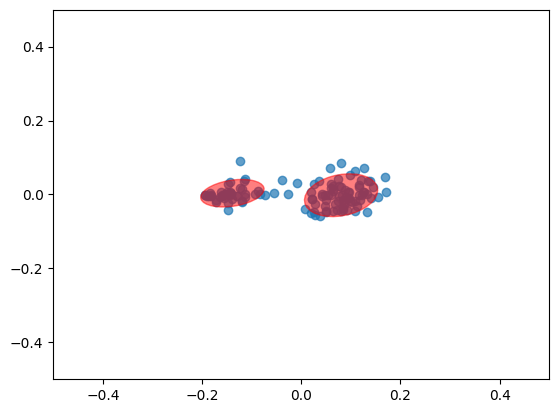

In [155]:
c = .8
gm, pca = do_clustering(data, confidence_limit=c, cluster_threshold=0.3, overlap_allowance=0.2, use_weights=False, verbose=True)
do_projected_plot(gm, pca, data, c)

Pick the measures closest to the means of each cluster and play the audio.

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


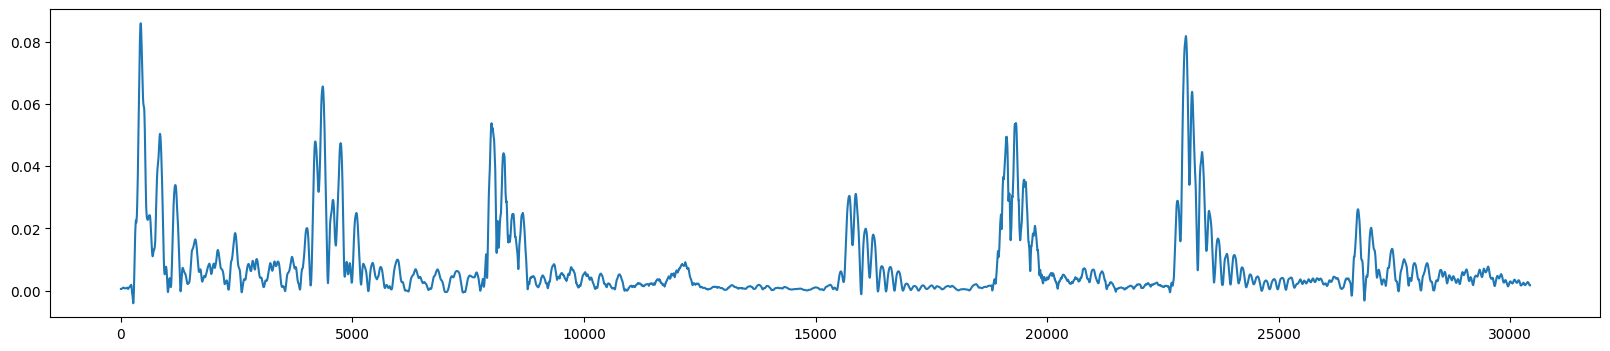

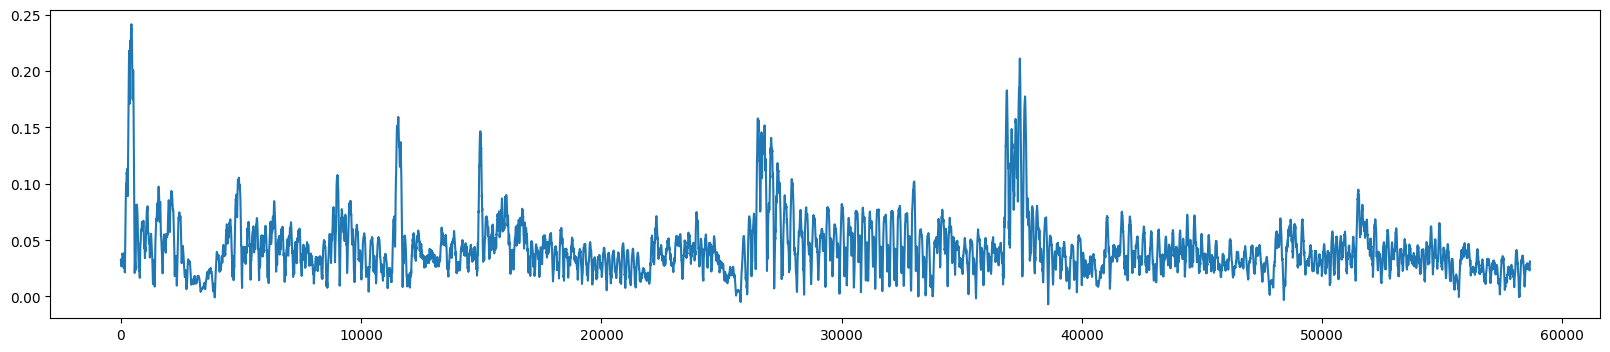

In [156]:
inds = find_closest_indices(gm.means_, data)
do_bar_sample(inds, file, smooth_power, ext)


# do_bar_sample(inds[inds < data_mk.shape[0]], 'milaklaw', smooth_power)
# do_bar_sample(inds[inds >= data_mk.shape[0]] - data_mk.shape[0], '06 Encore A', smooth_power)

Actual usage

In [2]:
import numpy as np
from groove.downbeats import smooth_power
from groove.embedding import load_bar_embedding_total
from groove.intraclustering import get_primary_gaussian_mean

file = '06 Encore A'
ext = 'mp3'

divs = np.array([3, 4, 6, 8, 9, 12, 16])
wts = 1/np.sqrt(divs)
data = load_bar_embedding_total(file, divs, wts, smooth_power, ext=ext, concatenate=True)
measure = get_primary_gaussian_mean(data)

print(measure.shape)


[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


Failed because clusters beneath required coverage.
Failed because clusters beneath required coverage.
(58,)
